In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# Config plt.
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')
rcParams['figure.figsize'] = 8, 5

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_boxplot, geom_histogram, facet_grid, ggtitle

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_excel('../data/Data_Train.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


### Data Cleaning

In [3]:
# Make feature names lower case.
df.columns = df.columns.str.lower()

# Change "data_of_journey" type to datetime.
df.date_of_journey = pd.to_datetime(df.date_of_journey, infer_datetime_format=True)

# Create "year", "month", "day" features.
df['year'] = pd.DatetimeIndex(df.date_of_journey).year
df['month'] = pd.DatetimeIndex(df.date_of_journey).month
df['day'] = pd.DatetimeIndex(df.date_of_journey).day

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

Updated dataframe shape: (10683, 14)


In [4]:
# Convert "duration to seconds"
df.duration = df.duration.apply(lambda x: f'{x} 0m' if not 'm' in x else x)
df.duration = df.duration.apply(lambda x: f'0h {x}' if not 'h' in x else x)
df.duration = df.duration.apply(lambda x: int(x.split()[0][:-1])*3600 + int(x.split()[1][:-1])*60)
df.duration.dtype

dtype('int64')

In [5]:
# Find "year" value counts.
print(df.year.value_counts())

# Drop "year" since its value is the same for all entires.
df.drop(columns=['year'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

2019    10683
Name: year, dtype: int64
Updated dataframe shape: (10683, 13)


In [6]:
print(df.additional_info.value_counts(), end='\n\n')

# Modify "additional_info" value "No Infor" to "No info"
df.additional_info = df.additional_info.str.replace('No Info', 'No info')

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: additional_info, dtype: int64

Updated dataframe shape: (10683, 13)


In [7]:
# Check for Null values.
print(df.isna().sum(), end='\n\n')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

airline            0
date_of_journey    0
source             0
destination        0
route              1
dep_time           0
arrival_time       0
duration           0
total_stops        1
additional_info    0
price              0
month              0
day                0
dtype: int64

Updated dataframe shape: (10682, 13)


In [8]:
# Check for duplicated entries.
print(f'Total number of duplicated entries: {df.duplicated().sum()}', end='\n\n')

# Drop douplicated entires.
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Print updated dataframe shape.
print(f'Updated dataframe shape: {df.shape}')

Total number of duplicated entries: 220

Updated dataframe shape: (10462, 13)


In [9]:
# Modify "total_stops" values to contain only the number.
df.total_stops = df.total_stops.apply(lambda x: int(x.split()[0]) if not 'non-stop' in x.split()[0] else 0)
print(df.total_stops.dtype, end='\n\n')

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

int64

Updated dataframe shape: (10462, 13)


In [215]:
# Categorize "dep_time"and "arrival_time".
def categorizee_time(input):
    time = input.split()[0]
    if int(time[:2]) >= 0 and int(time[:2]) < 6:
        return 'mid_night'
    elif int(time[:2]) >= 6 and int(time[:2]) < 12:
        return 'morning'
    elif int(time[:2]) >= 12 and int(time[:2]) < 18:
        return 'afternoon'
    elif int(time[:2]) >= 18 and int(time[:2]) < 24:
        return 'evening'

df.dep_time = df.dep_time.apply(categorizee_time)
df.arrival_time = df.arrival_time.apply(categorizee_time)

In [219]:
df.drop(columns=['date_of_journey', 'route'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Print dataframe updated shape.
print(f'Updated dataframe shape: {df.shape}')

Updated dataframe shape: (10462, 11)


In [220]:
df.head()

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,month,day
0,IndiGo,Banglore,New Delhi,evening,mid_night,10200,0,No info,3897,3,24
1,Air India,Kolkata,Banglore,mid_night,afternoon,26700,2,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,morning,mid_night,68400,2,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,evening,evening,19500,1,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,afternoon,evening,17100,1,No info,13302,3,1


### EDA

In [222]:
# Display stats summary of numeric values.
df.describe()

,duration,total_stops,price,month,day
count,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000
mean,37786.895431,0.802332,9026.790289,4.701491,13.463200
std,30041.942724,0.660609,4624.849541,1.163802,8.467493
min,300.000000,0.000000,1759.000000,3.000000,1.000000
25%,10200.000000,0.000000,5224.000000,3.000000,6.000000
50%,30300.000000,1.000000,8266.000000,5.000000,12.000000
75%,54600.000000,1.000000,12344.750000,6.000000,21.000000
max,171600.000000,4.000000,79512.000000,6.000000,27.000000


In [223]:
# Display summery stats on categorical features.
df.describe(include=['O'])

,airline,source,destination,dep_time,arrival_time,additional_info
count,10462,10462,10462,10462,10462,10462
unique,12,5,6,4,4,9
top,Jet Airways,Delhi,Cochin,morning,evening,No info
freq,3700,4345,4345,4224,4268,8185


In [13]:
# Display the correlation between the different features.
df.corr().style.background_gradient()

,duration,total_stops,price,month,day
duration,1.000000,0.727982,0.501758,0.004874,-0.029810
total_stops,0.727982,1.000000,0.602013,0.039003,-0.018937
price,0.501758,0.602013,1.000000,-0.113396,-0.159044
month,0.004874,0.039003,-0.113396,1.000000,-0.038331
day,-0.029810,-0.018937,-0.159044,-0.038331,1.000000


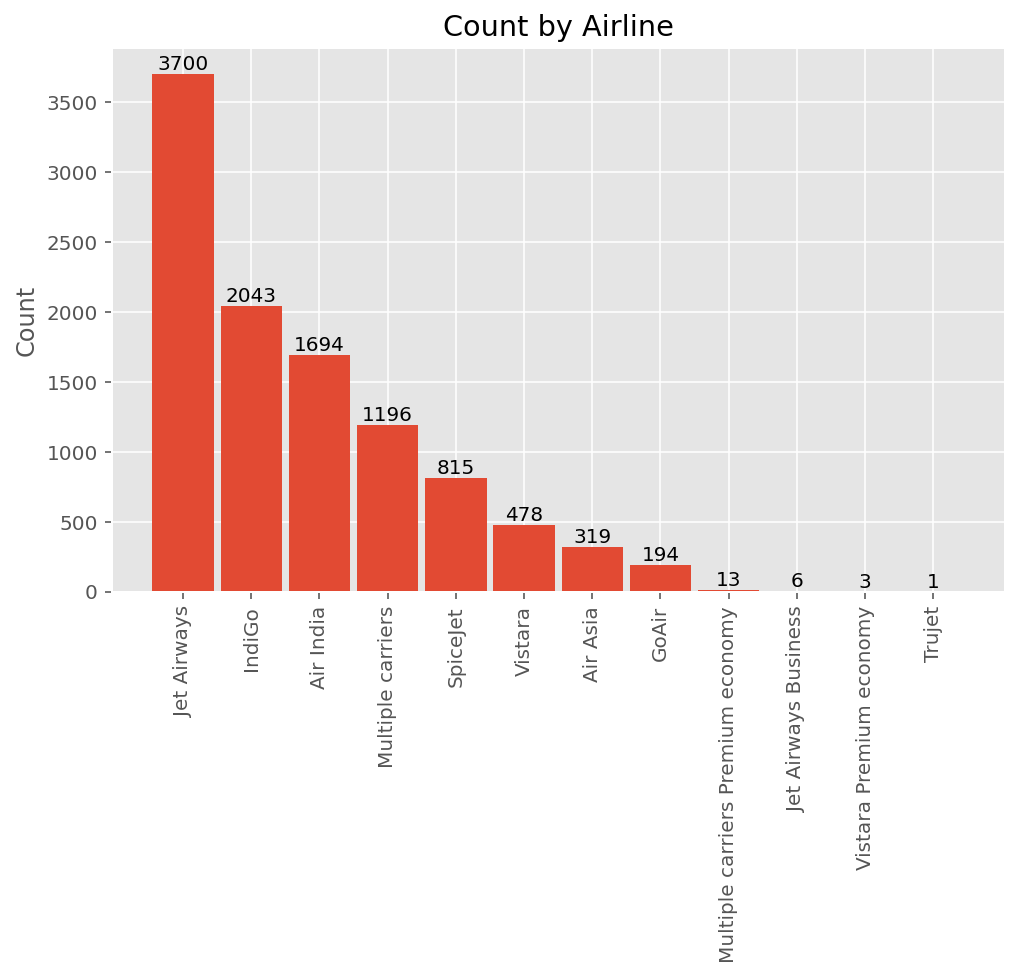

In [83]:
# Find the count of "airline".
airline_count = df.airline.value_counts()

# Plot a bar plot for the count of "airline".
x = np.arange(len(airline_count.index))
width = 0.9
fig, ax = plt.subplots()
bars = ax.bar(x - width/2, airline_count.values, width)
ax.set_ylabel('Count')
ax.set_title('Count by Airline')
ax.set_xticks(x - width/2, airline_count.index)
ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

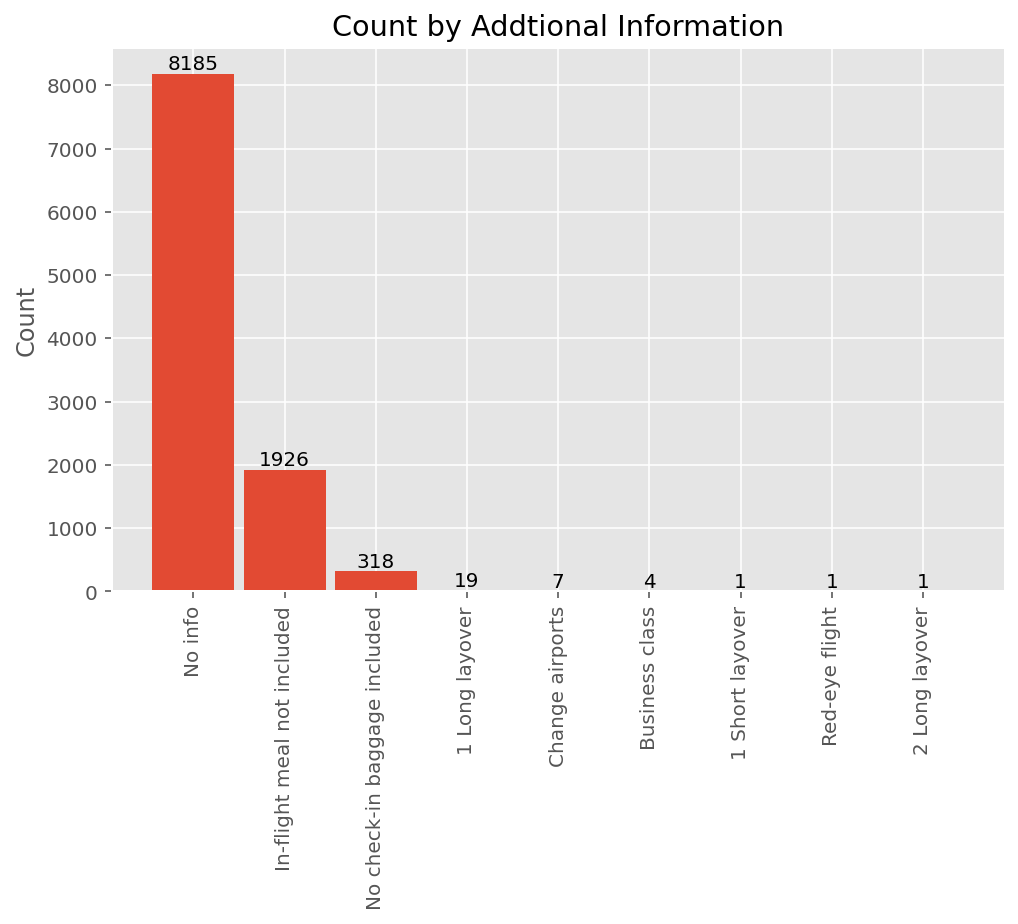

In [82]:
# Find the count of "addtional_info".
additional_info_count = df.additional_info.value_counts()

# Plot a bar plot for the count of "addtional_info".
x = np.arange(len(additional_info_count.index))
width = 0.9
fig, ax = plt.subplots()
bars = ax.bar(x - width/2, additional_info_count.values, width)
ax.set_ylabel('Count')
ax.set_title('Count by Addtional Information')
ax.set_xticks(x - width/2, additional_info_count.index)
ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

c:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'Price Distribution')

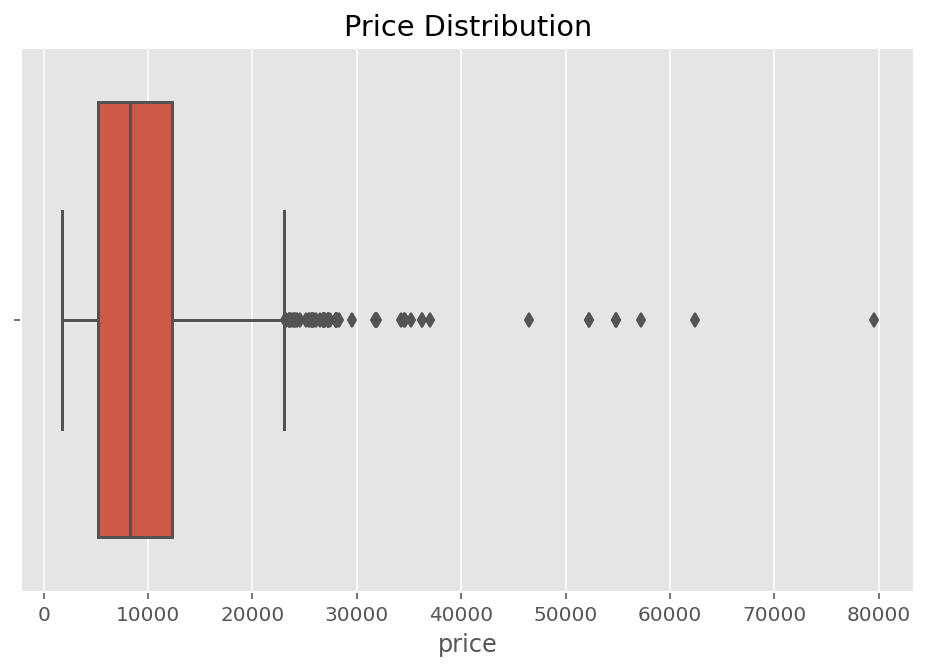

In [91]:
# Plot a box plot of "price".
sns.boxplot(df.price)
plt.title('Price Distribution')

Text(0.5, 1.0, 'Price Distribution')

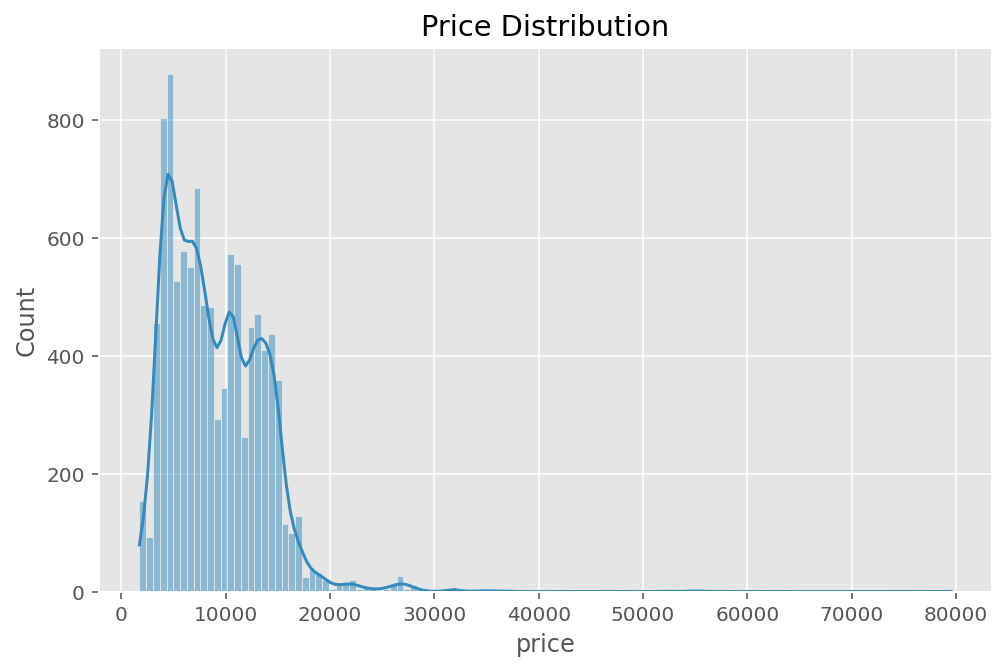

In [100]:
sns.histplot(df.price, kde=True)
plt.title('Price Distribution')

Text(0.5, 1.0, 'Distripution of Flight by Ticket Price Median')

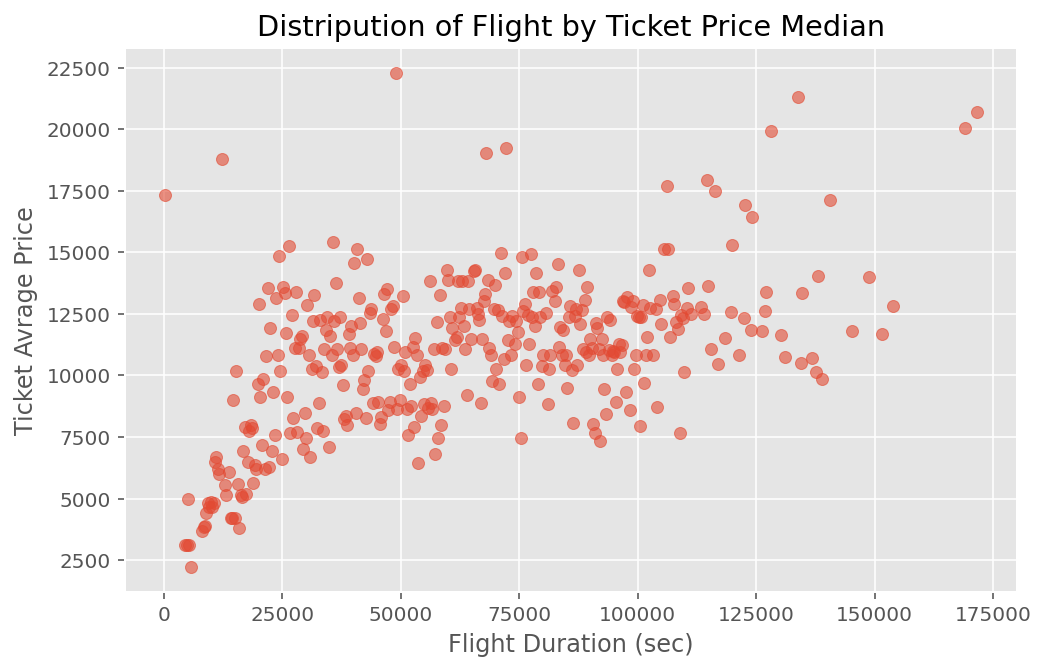

In [81]:
# Group median of each feature median value values by "duration".
# Note: median was chosen because price distribution is positively-skewed.
avg_price_per_duration = df.groupby(['duration'], as_index=False).median()

# Plot a scatter plot of "price" with respect to "duration".
plt.scatter(x=avg_price_per_duration.duration, y=avg_price_per_duration.price, alpha=0.6)
plt.xlabel('Flight Duration (sec)')
plt.ylabel('Ticket Avrage Price')
plt.title('Distripution of Flight by Ticket Price Median')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'No info'),
  Text(1, 0, 'In-flight meal not included'),
  Text(2, 0, 'No check-in baggage included'),
  Text(3, 0, '1 Short layover'),
  Text(4, 0, '1 Long layover'),
  Text(5, 0, 'Change airports'),
  Text(6, 0, 'Business class'),
  Text(7, 0, 'Red-eye flight'),
  Text(8, 0, '2 Long layover')])

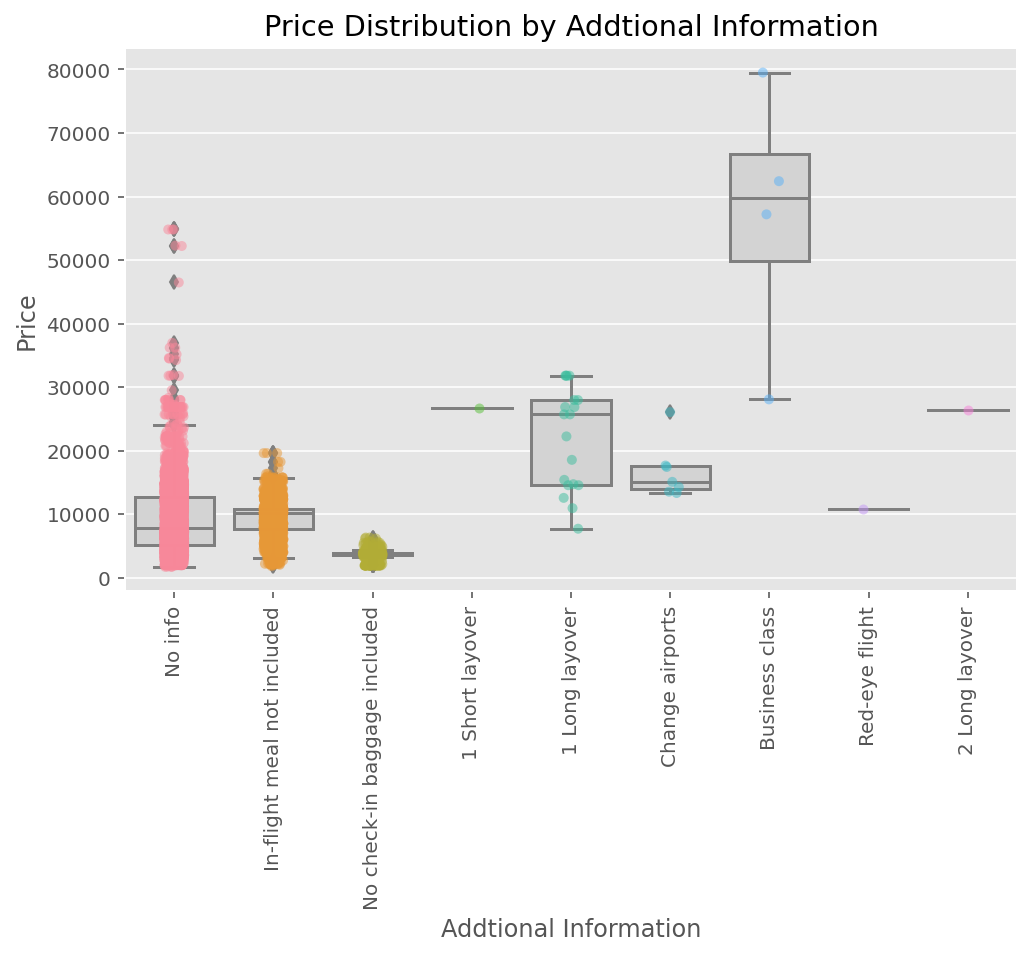

In [193]:
sns.stripplot(data=df, x='additional_info', y='price', jitter=True, alpha=0.5)
sns.boxplot(df.additional_info, df.price, color='lightgray')
plt.xlabel('Addtional Information')
plt.ylabel('Price')
plt.title('Price Distribution by Addtional Information')
plt.xticks(rotation=90)

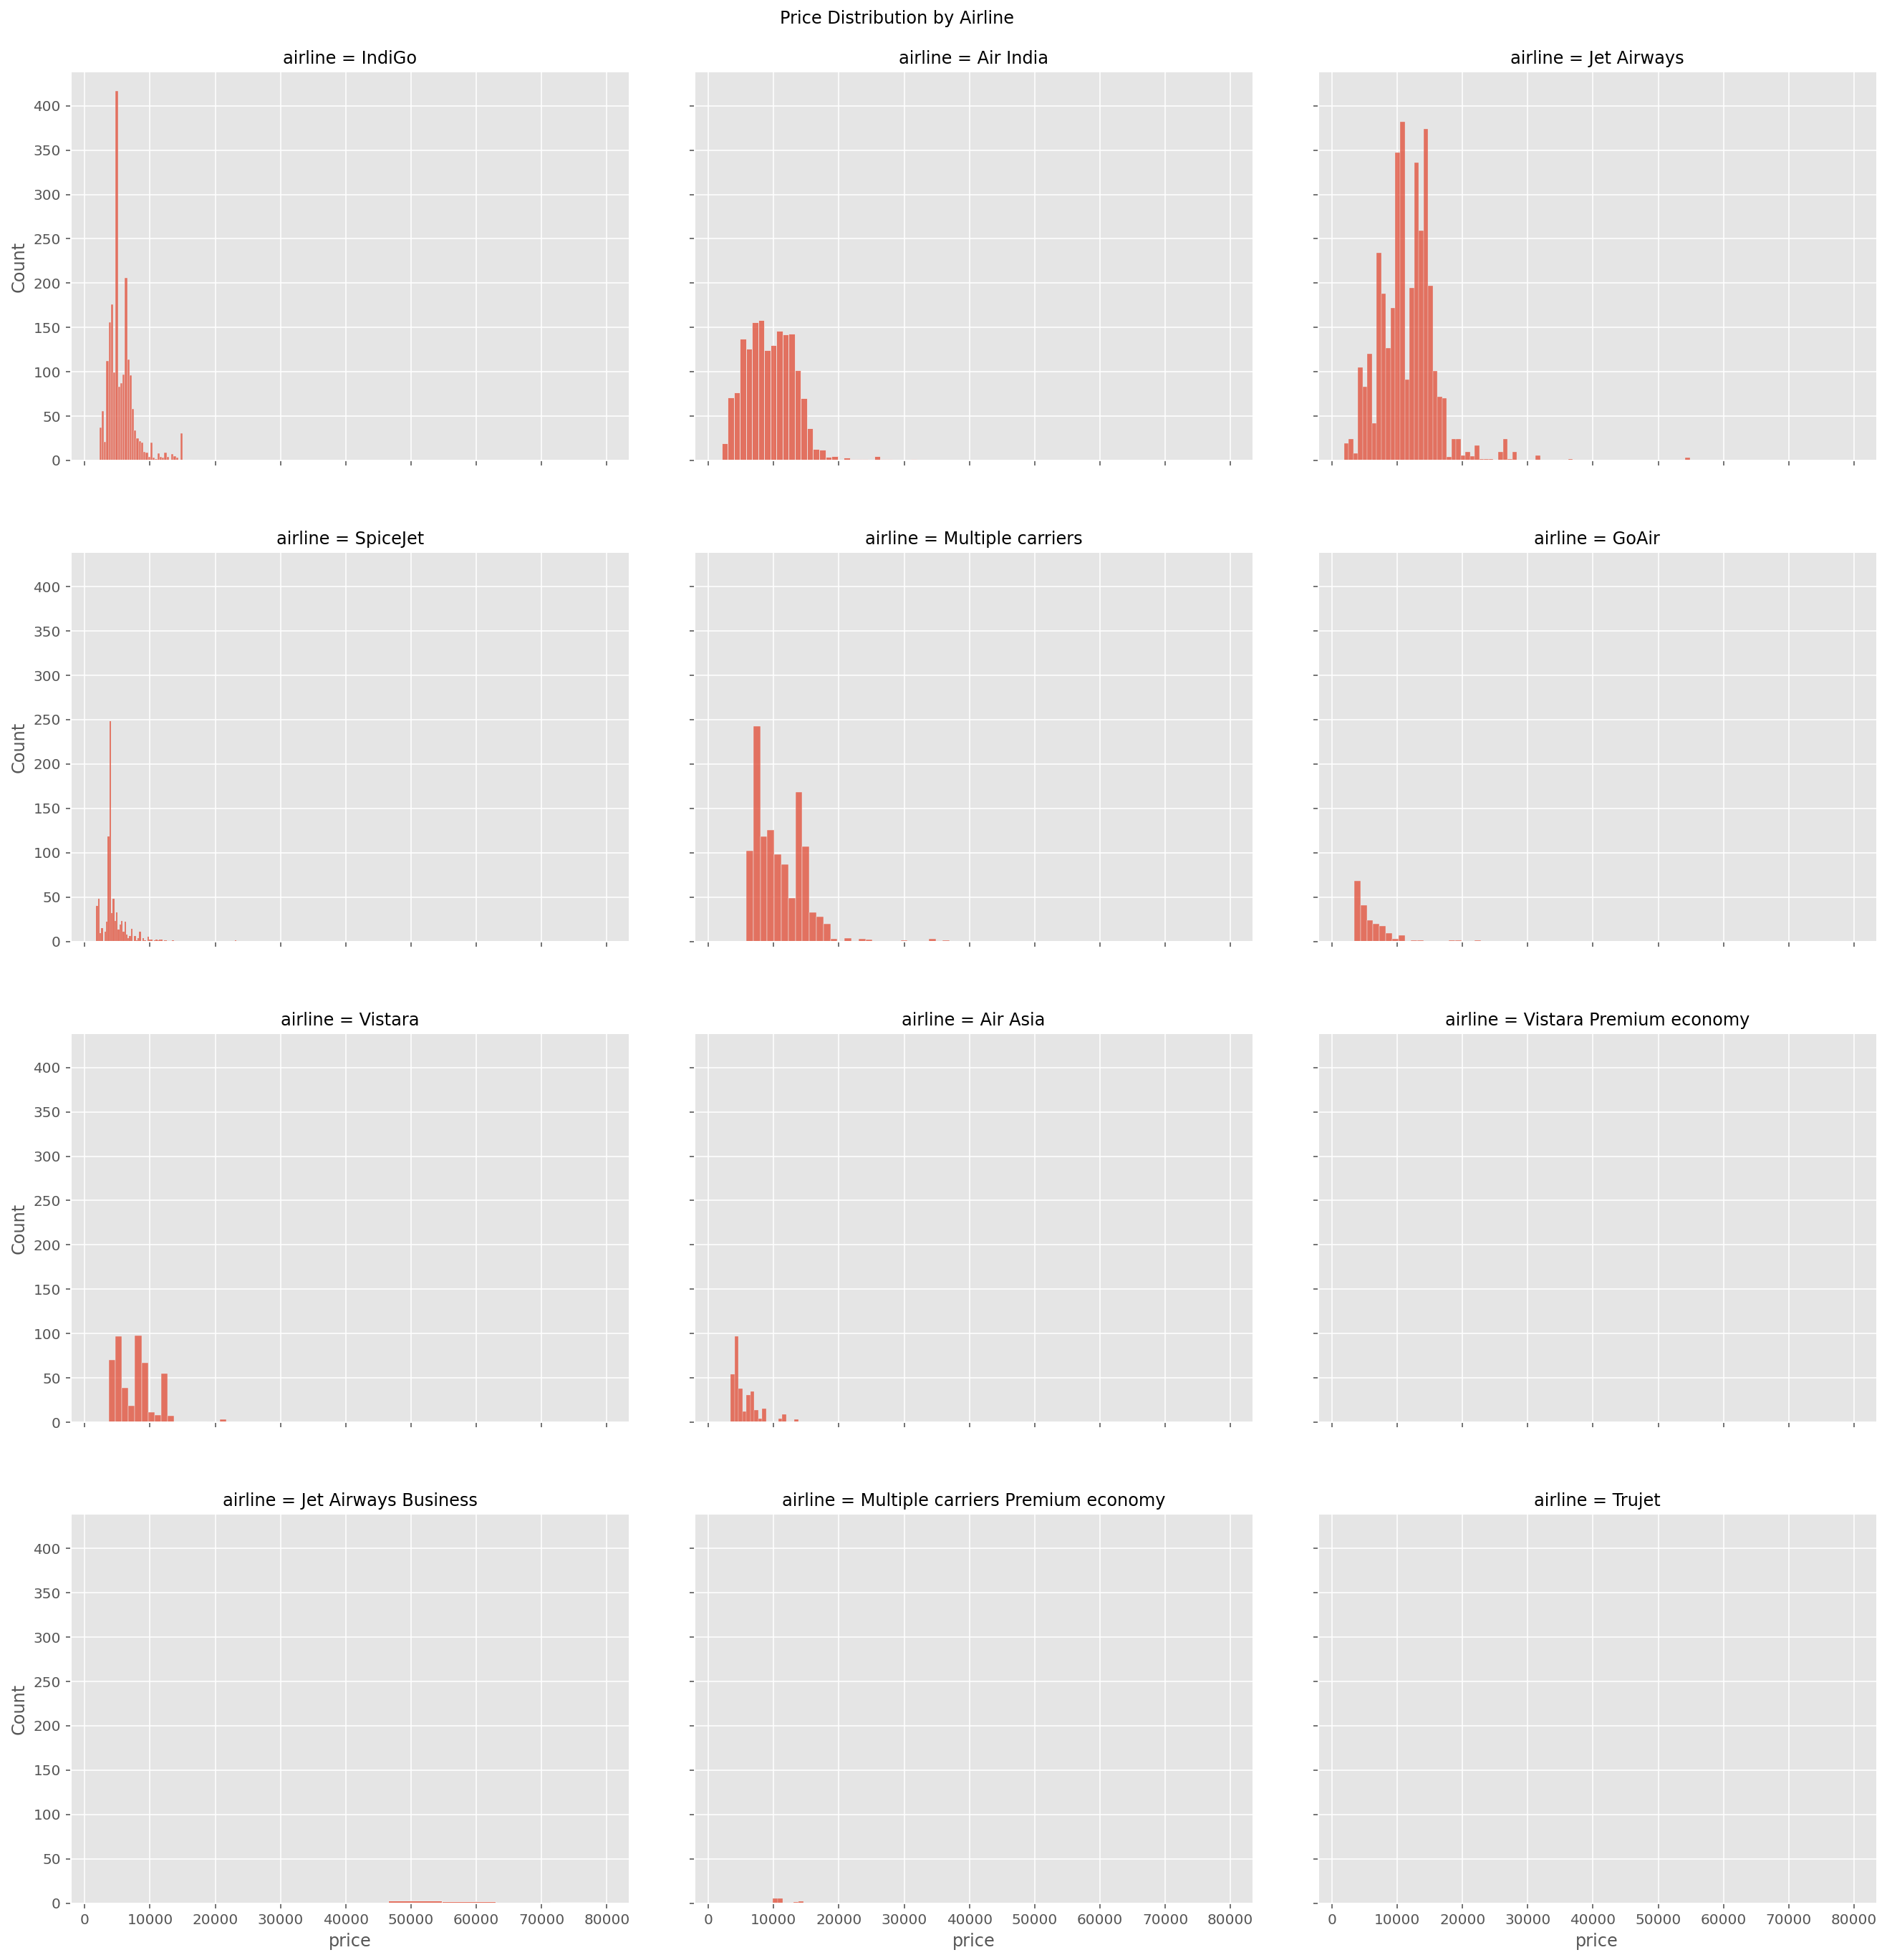

In [188]:
g = sns.FacetGrid(df, col='airline', height=2.5, col_wrap=3)
g.map(sns.histplot, 'price')
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Price Distribution by Airline')
g.fig.set_figwidth(20)
g.fig.set_figheight(20)

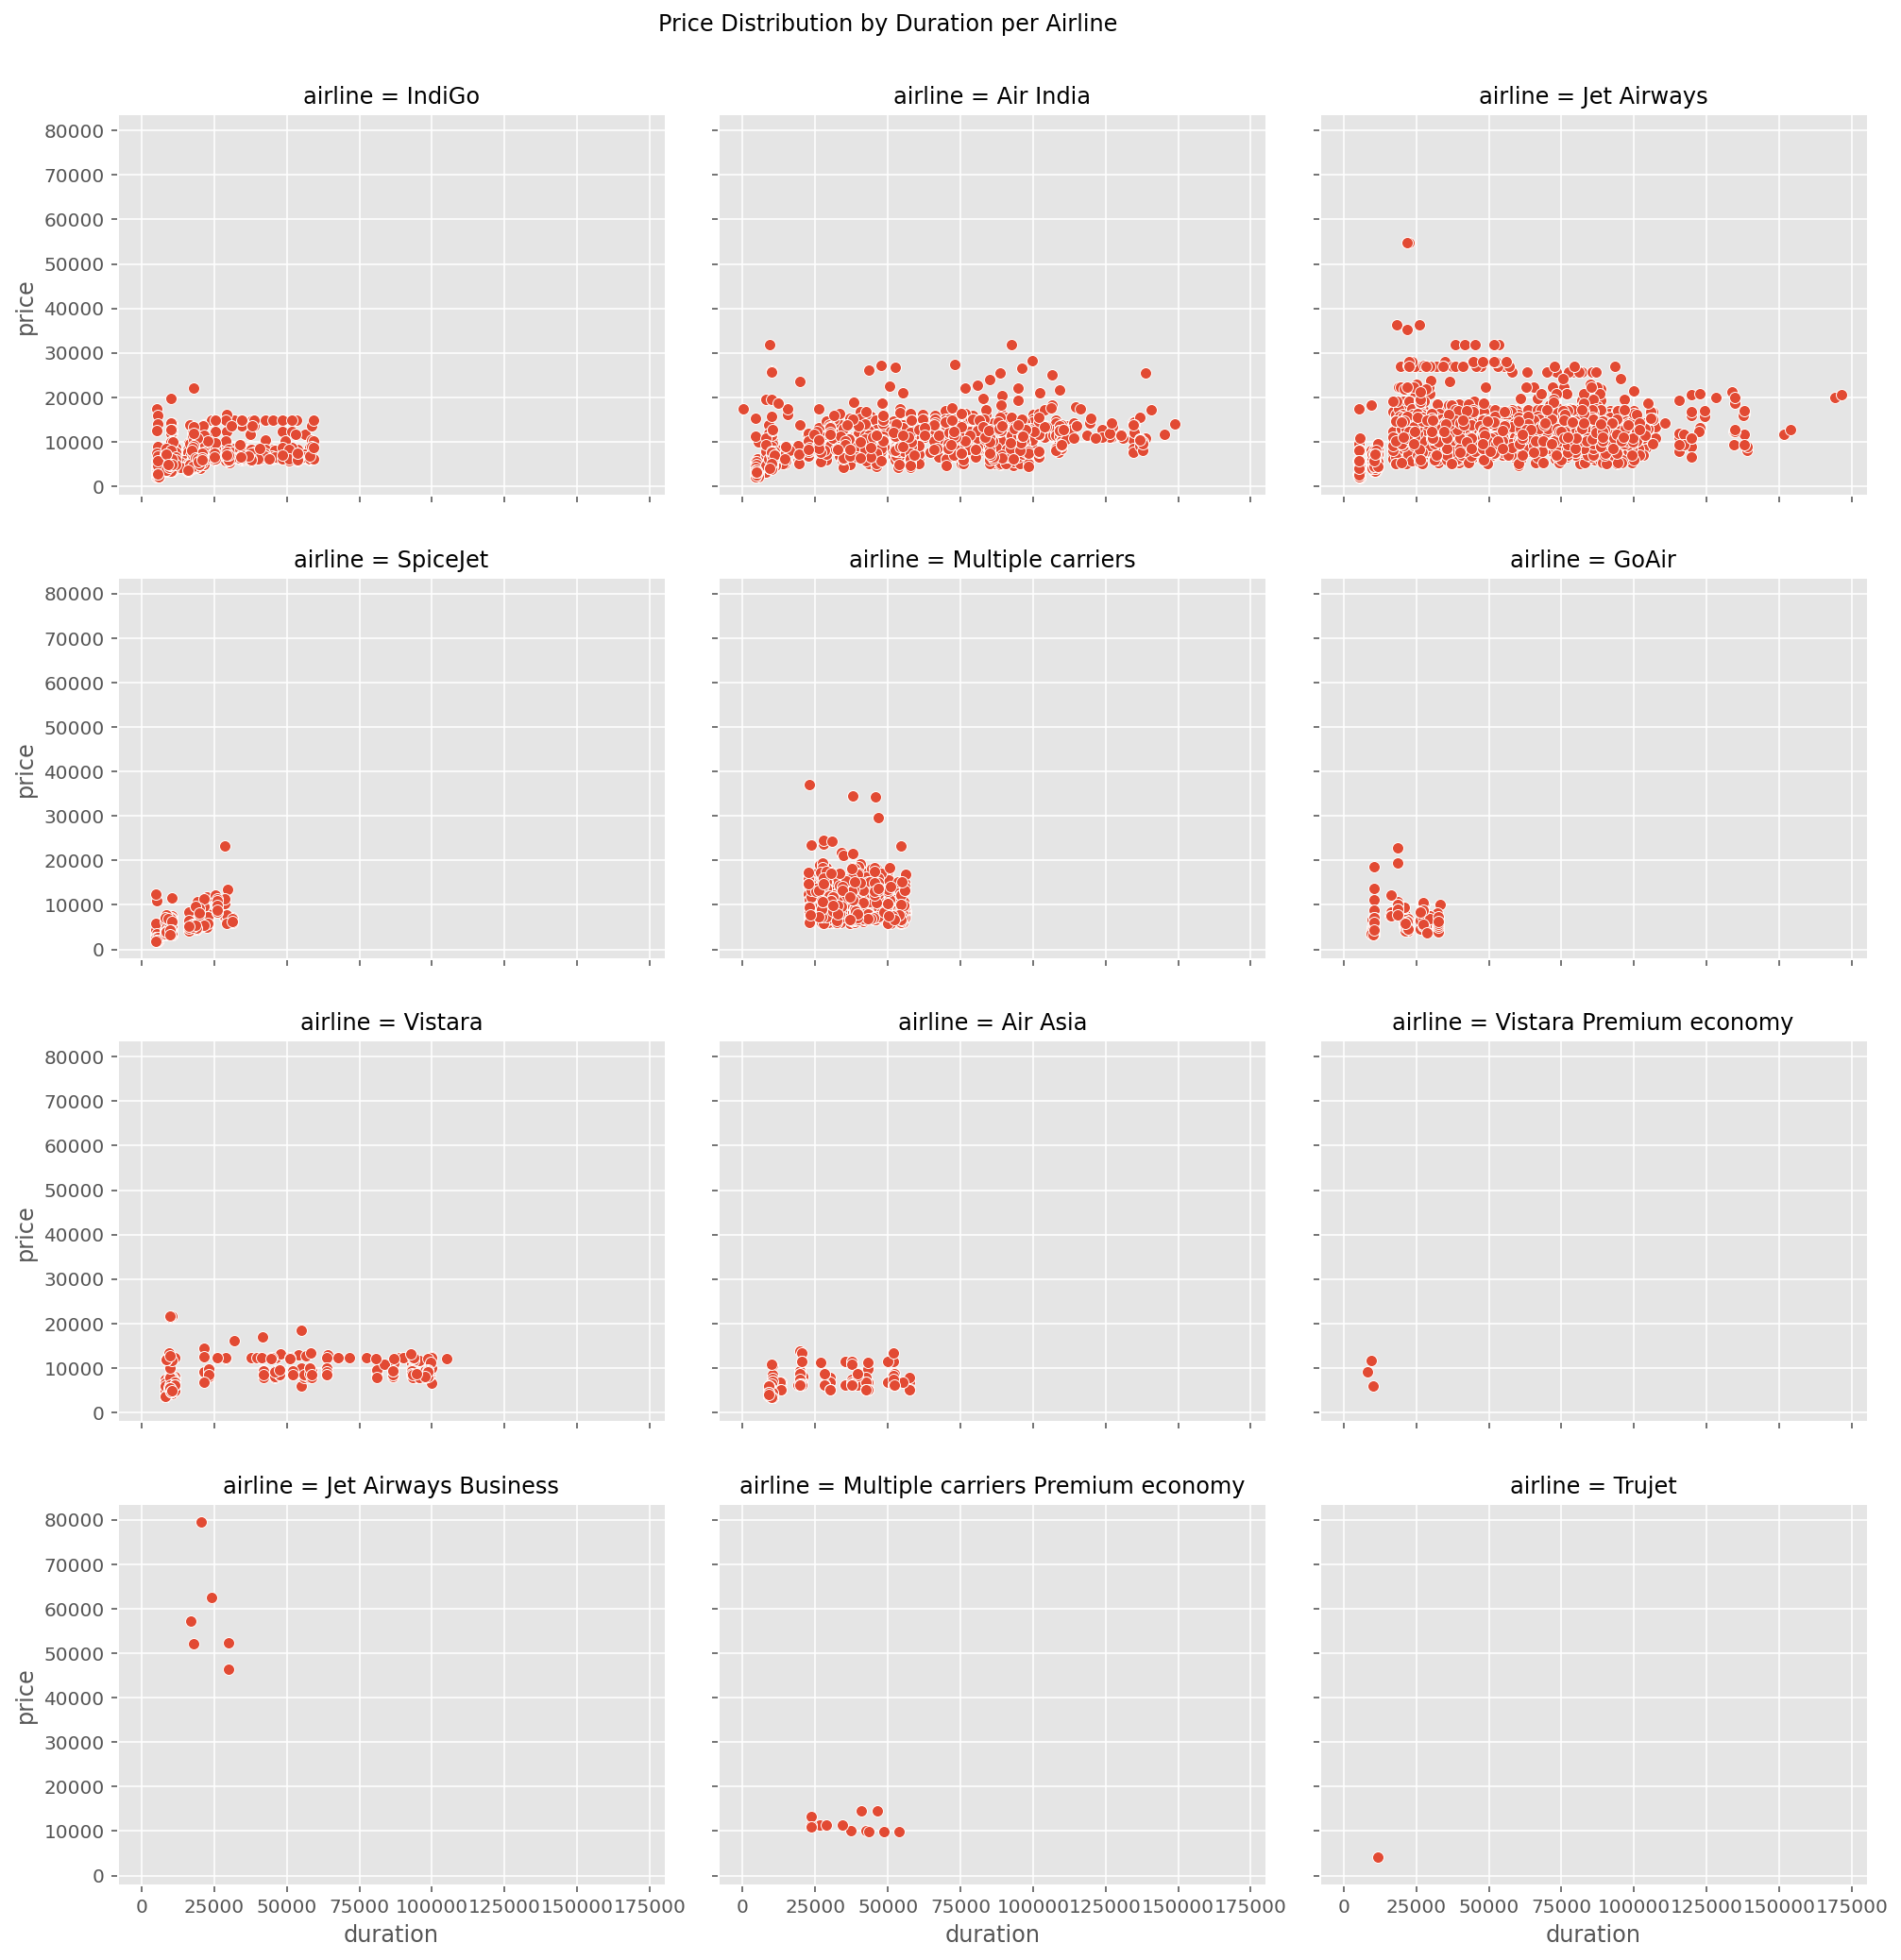

In [198]:
g = sns.FacetGrid(data=df, col='airline', height=2.5, margin_titles=True, col_wrap=3)
g.map(sns.scatterplot, 'duration', 'price')
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Price Distribution by Duration per Airline')
g.fig.set_figwidth(15)
g.fig.set_figheight(15)

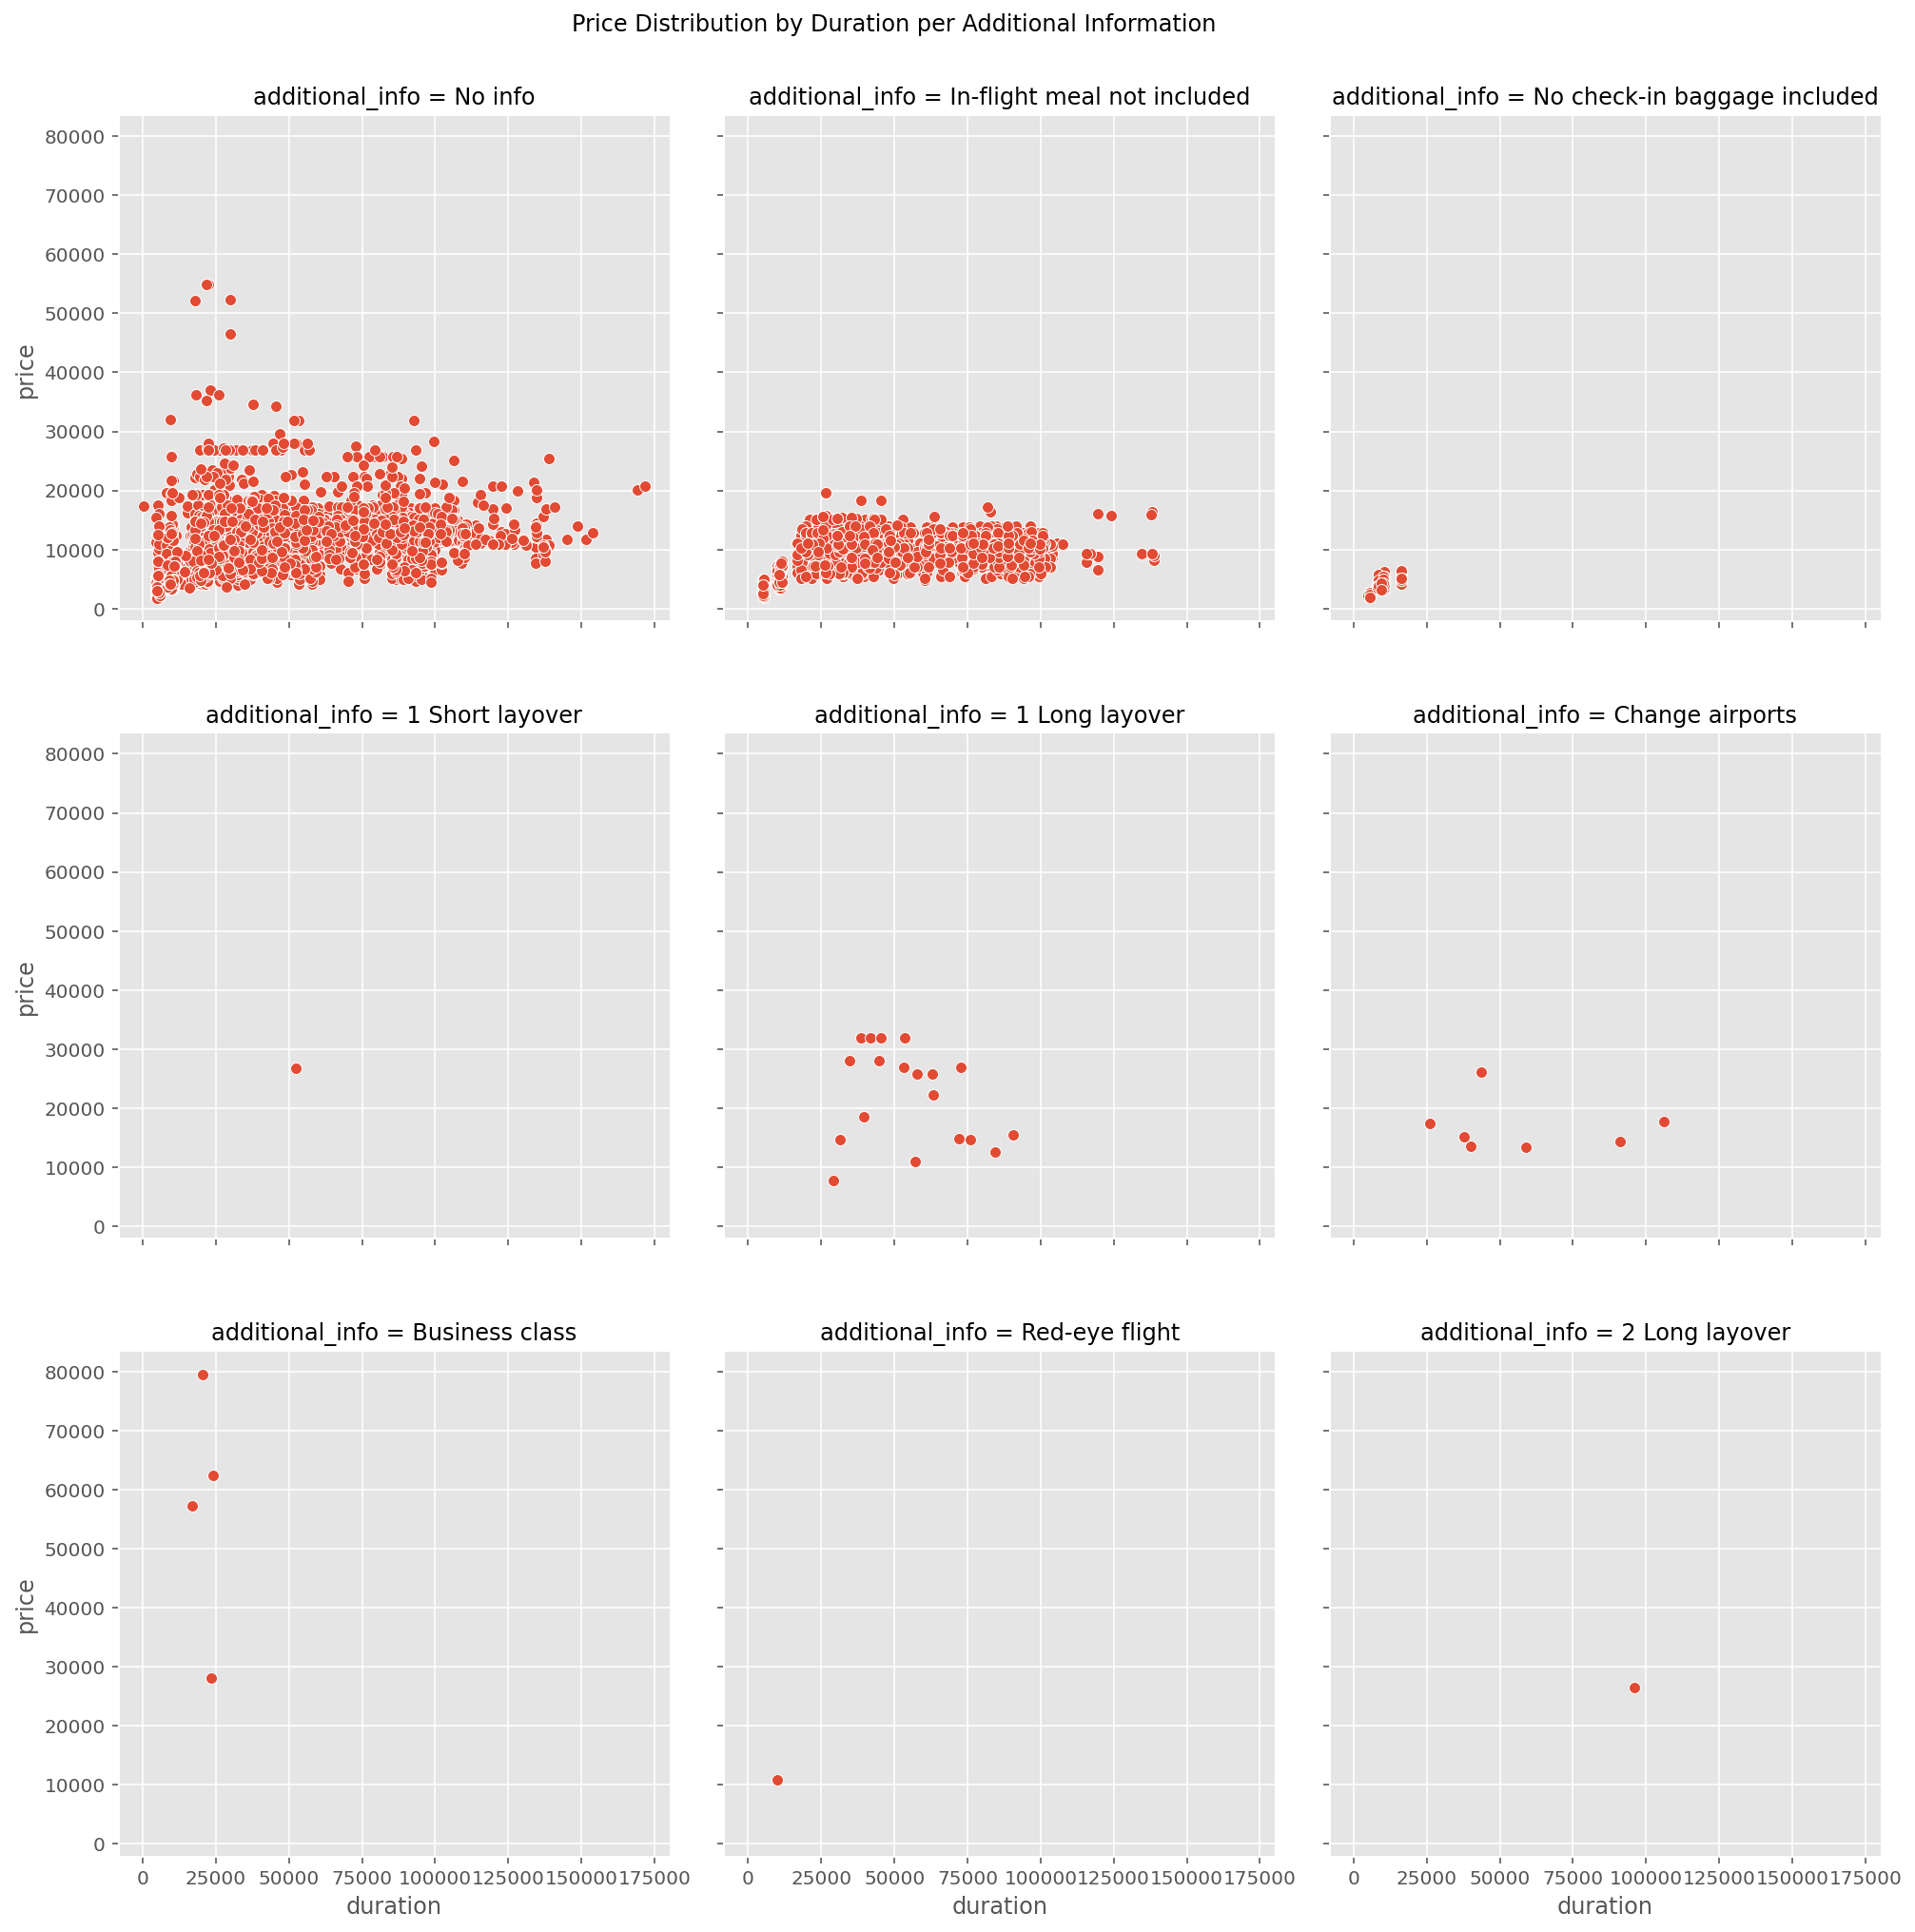

In [197]:
g = sns.FacetGrid(data=df, col='additional_info', height=2.5, margin_titles=True, col_wrap=3)
g.map(sns.scatterplot, 'duration', 'price')
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Price Distribution by Duration per Additional Information')
g.fig.set_figwidth(15)
g.fig.set_figheight(15)

### Machine Learning

In [261]:
# Split the data into train and test splits.
train, test = train_test_split(df, train_size=0.8, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

#### KNN

In [283]:
# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10)#, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()

# One-hot encode remaining categorical features.
encoder = OneHotEncoder(handle_unknown="ignore")

# combine all steps into a preprocessing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("std_encode", scaler, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object"))
  ])

print(preprocessor, end='\n\n')

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])

print(100*'-', end='\n\n')
print(model_pipeline)

ColumnTransformer(remainder='passthrough',
                  transformers=[('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F990166D0>),
                                ('one-hot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F99038160>)])

----------------------------------------------------------------------------------------------------

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_encode',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F990166D0>),
                                                 ('one-hot',

In [284]:
# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
print(f'Best RMSE: {abs(results.best_score_)}', end='\n\n')

# Best model's k value
print(f'Best K number: {results.best_estimator_.get_params().get("knn__n_neighbors")}')

Best RMSE: 2142.801354153572

Best K number: 3


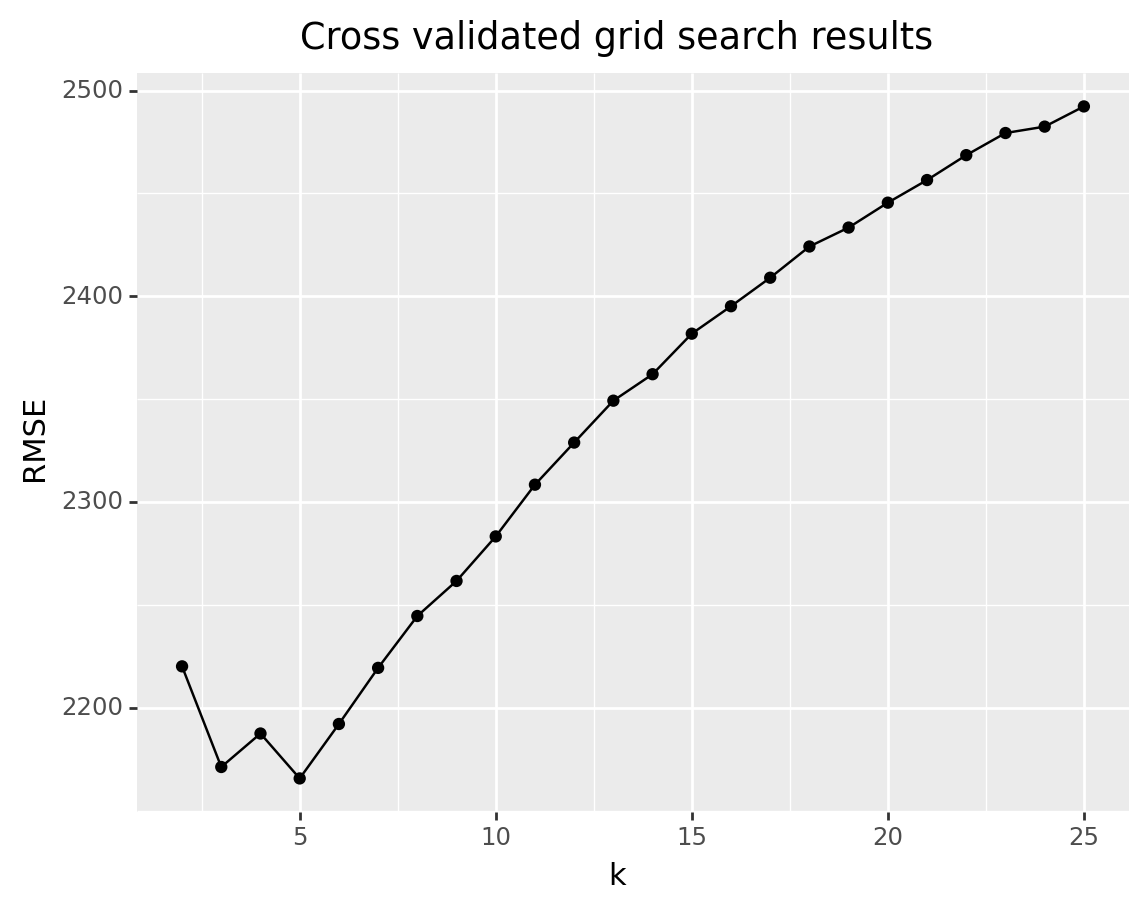

<ggplot: (102951767248)>

In [267]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))